# 1. Why DistilBERT for Sentiment Analysis?
  * DistilBERT is a smaller, faster version of BERT, making it ideal for tasks like sentiment analysis.
  * Pre-trained DistilBERT models are available on Hugging Face, making fine-tuning or direct usage simple.

# 2. Installation
Make sure to install the necessary libraries:

In [8]:
!pip install transformers datasets torch

For GPU support, ensure PyTorch with CUDA is installed. Verify GPU access:

In [9]:
import torch
print(torch.cuda.is_available())  # Should return True

True


# 3. Code Example: Sentiment Analysis with DistilBERT
Below is a script to fine-tune DistilBERT on the IMDB dataset:

In [11]:
from datasets import load_dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments

In [12]:
# Load IMDB dataset
dataset = load_dataset("imdb")

# Load tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [30]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50000 [00:00<?, ? examples/s]

Tokenized dataset saved to 'tokenized_imdb_dataset'


In [14]:
# Prepare datasets for PyTorch
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [15]:
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10000))  # Smaller subset for quick training
test_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(2000))


In [16]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_first_step=True
)

# Define Trainer
def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
# Train model and capture training history
train_results = trainer.train()
trainer.save_model()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: ERROR API key must be 40 characters long, yours was 17


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [36]:
# !zip -r "/content/drive/MyDrive/Colab Notebooks/ SentimentAnalysis/results.zip" results/

updating: results/ (stored 0%)
updating: results/config.json (deflated 46%)
updating: results/checkpoint-625/ (stored 0%)
updating: results/checkpoint-625/config.json (deflated 46%)
updating: results/checkpoint-625/trainer_state.json (deflated 80%)
updating: results/checkpoint-625/scheduler.pt (deflated 56%)
updating: results/checkpoint-625/optimizer.pt (deflated 15%)
updating: results/checkpoint-625/model.safetensors (deflated 8%)
updating: results/checkpoint-625/training_args.bin (deflated 51%)
updating: results/checkpoint-625/rng_state.pth (deflated 25%)
updating: results/model.safetensors (deflated 8%)
updating: results/training_args.bin (deflated 51%)
updating: results/checkpoint-1875/ (stored 0%)
updating: results/checkpoint-1875/config.json (deflated 46%)
updating: results/checkpoint-1875/trainer_state.json (deflated 82%)
updating: results/checkpoint-1875/scheduler.pt (deflated 56%)
updating: results/checkpoint-1875/optimizer.pt (deflated 15%)
updating: results/checkpoint-1875/m

In [18]:
# Evaluate
eval_results = trainer.evaluate()


In [19]:
# Visualization: Extracting training logs
history = trainer.state.log_history

# Separate out losses and accuracies
train_loss = [log['loss'] for log in history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in history if 'eval_loss' in log]
eval_acc = [log['eval_accuracy'] for log in history if 'eval_accuracy' in log]


In [21]:
import matplotlib.pyplot as plt

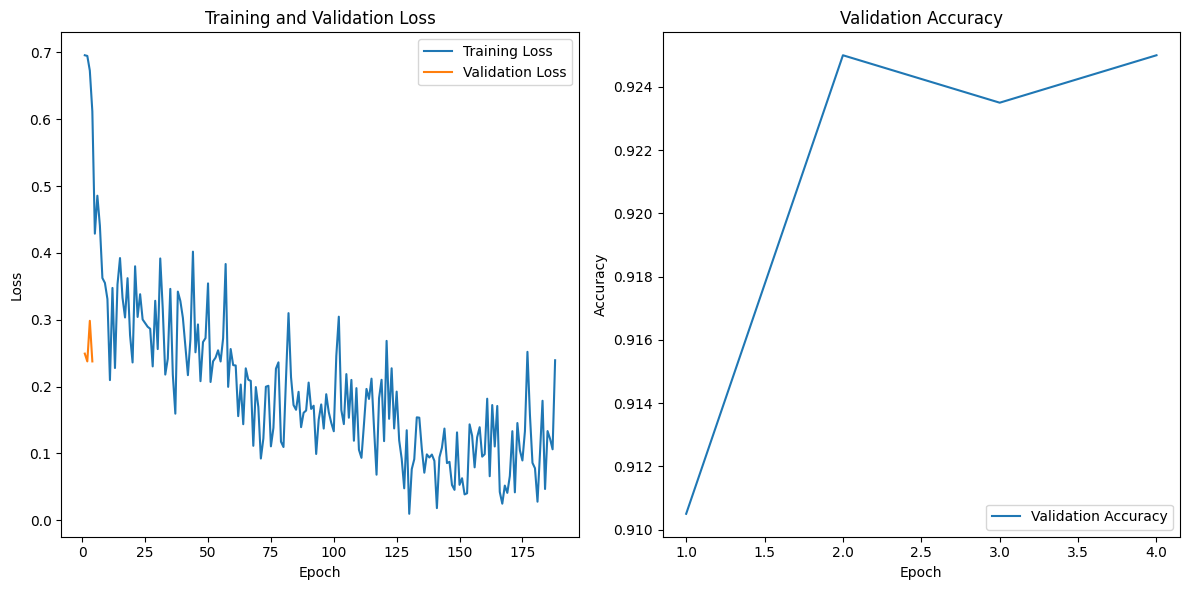

In [27]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(eval_loss) + 1), eval_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(eval_acc) + 1), eval_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Print evaluation results
print("Evaluation Results:", eval_results)

Evaluation Results: {'eval_loss': 0.23756597936153412, 'eval_accuracy': 0.925, 'eval_runtime': 30.5137, 'eval_samples_per_second': 65.544, 'eval_steps_per_second': 4.097, 'epoch': 3.0}


In [26]:
plt.savefig("training_history.png")

<Figure size 640x480 with 0 Axes>

# 4. Loading a Model and Tokenizer

Here’s the code to load the saved model:

In [32]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# Path to the directory where the model was saved
model_dir = "results"

# Load the model
model = DistilBertForSequenceClassification.from_pretrained(model_dir)

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

print("Model and tokenizer loaded successfully!")

Model and tokenizer loaded successfully!


# 5. Using the Loaded Model

Once the model is loaded, you can use it for tasks like sentiment analysis or other predictions.

Example: Sentiment Analysis

In [33]:
# Example text for prediction
text = "I love this movie, it was amazing!"

# Tokenize the input text
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Run the model and get predictions
with torch.no_grad():
    outputs = model(**inputs.to(device))

# Get predicted class (since it's binary classification, class 0 or 1)
predicted_class = torch.argmax(outputs.logits, dim=-1).item()

# Display result
if predicted_class == 1:
    print(f"Prediction: Positive sentiment")
else:
    print(f"Prediction: Negative sentiment")

Prediction: Positive sentiment
